<a href="https://colab.research.google.com/github/sling1678/ML_programs_for_video_lectures/blob/main/prostate_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem
Stamey et al (1989), "Prostate specific antigen (PSA) in the diagnosis and treatment of adenocarcinoma of the prostate II radical prostatectomy treated patients", Journal of Urology, vol 16, 1076-1083. A copy of Abstract here, https://pubmed.ncbi.nlm.nih.gov/2468795/. 

The statistical learning problem is to predict y = (log of PSA) from 8 other variables.

x_1 = log of cancer volume (lcavol); NUMERICAL

x_2 = log of prostate weight (lweight); NUMERICAL

x_3 = age (age); NUMERICAL

x_4 = log of amount of benign prostatic hyperplasia (lbph); NUMERICAL

x_5 = seminal vesicle invasion (svi); INTEGER_CATEGORICAL

x_6 = log of capsular penetration (lcp); NUMERICAL

x_7 = Gleason score (gleason); INTEGER_CATEGORICAL

x_8 = percent of Gleason scores 4 or 5 (pgg45). NUMERICAL

In [1]:
#IMPORTS
import os # for environment
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.model_selection  # we might use train_test_split to create validation set for hyperparameter(s)

#-----------------

In [2]:
# GLOBALS
BATCH_SIZE=16
EPOCHS=2000
TRIALS=30
EXPERIMENTING = False # Make it False for final

In [3]:
#-------------- Seed random behavior to get consistent results
def set_seeds(seed):
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)
    
def set_global_determinism(seed):
  
  random_state =  sklearn.utils.check_random_state(seed)
  set_seeds(seed=seed)

  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
  tf.config.threading.set_inter_op_parallelism_threads(1)
  tf.config.threading.set_intra_op_parallelism_threads(1)
  return random_state

# Call the above function with seed value 

if EXPERIMENTING:
  random_state = set_global_determinism(seed=43) # for sklearn
else:
  seed = np.random.randint(3, 333333333)
  random_state = set_global_determinism(seed)

In [4]:
# Dataframes for this project
DATA_URL = "https://hastie.su.domains/ElemStatLearn/datasets/prostate.data"

TARGET = 'lpsa'
TRAINING_SET_SELECTOR = ['train']
NUMERICAL_FEATURES = ['lcavol', 'lweight', 'age', 'lbph',  'lcp',  'pgg45']
STRING_CATEGORICAL_FEATURES = []
INTEGER_CATEGORICAL_FEATURES = ['svi','gleason',]
FEATURES = NUMERICAL_FEATURES + STRING_CATEGORICAL_FEATURES + INTEGER_CATEGORICAL_FEATURES

#-------------------GET DATAFRAME
df = pd.read_csv(DATA_URL, sep='\t')
#-------------------CHECK IT
df.head(3)

,Unnamed: 0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T


I. Get Data and Prepare Pandas DataFrames

In [5]:
def prepare_Xy_dataframes(df, features, target, training_set_selector=None, test_frac=0.2, val_frac=0.2, verbose=0):
  df = df.copy()
  if training_set_selector is not None:
    df = df[features + [target] + training_set_selector] # this will drop fictitious columns that show up in the downloaded file
    train_df = df[df['train']=='T'].copy() # We will need a validation set for hyperparameters - we omit this step
    test_df = df[df['train'] != 'T'].copy()
    train_df.drop('train',axis=1, inplace=True)
    test_df.drop('train',axis=1, inplace=True)
  else:
    print(features)
    columns = features + [target]
    print(columns)
    df = df[columns]
    train_df, test_df = sklearn.model_selection.train_test_split(df, test_size=test_frac, random_state=random_state)
  
  train_df, val_df = sklearn.model_selection.train_test_split(train_df, test_size=val_frac)
  train_df.reset_index(drop=True, inplace=True)
  test_df.reset_index(drop=True, inplace=True)
  val_df.reset_index(drop=True, inplace=True)
  
  if verbose >= 1:
    print(f"Shapes: train {train_df.shape}, test {test_df.shape}, validation {val_df.shape}")
  if verbose > 1:
    print(f"first three rows of training data are:\n{train_df.head(3)}")

  return train_df, test_df, val_df

#----------------------   Check if randomness is absent; 
train_df, test_df, val_df = prepare_Xy_dataframes(df, features=FEATURES, target=TARGET, 
  training_set_selector=TRAINING_SET_SELECTOR, test_frac=0.2, verbose=2)
train_df, test_df, val_df = prepare_Xy_dataframes(df, features=FEATURES, target=TARGET, 
  training_set_selector=TRAINING_SET_SELECTOR, test_frac=0.2, verbose=2)

Shapes: train (53, 9), test (30, 9), validation (14, 9)
first three rows of training data are:
     lcavol   lweight  age      lbph  svi       lcp  gleason  pgg45      lpsa
0  1.477049  2.998229   67 -1.386294    0 -1.386294        7      5  1.348073
1  1.781709  3.451574   63  0.438255    0  1.178655        7     60  1.713798
2  1.562346  3.709907   60  1.695616    0  0.810930        7     30  3.587677
Shapes: train (53, 9), test (30, 9), validation (14, 9)
first three rows of training data are:
     lcavol   lweight  age      lbph  svi       lcp  gleason  pgg45      lpsa
0  0.285179  4.090169   65  1.962908    0 -0.798508        6      0  1.924249
1  0.463734  3.764682   49  1.423108    0 -1.386294        6      0  2.794228
2  2.010895  4.433789   72  2.122262    0  0.500775        7     60  3.392829


In [6]:
def print_a_batch(dataset):
  for feature_batch, target_batch in dataset.take(1):
    print(f"Features are: {list(feature_batch.keys())}")
    print(f"A batch of lcavol: {feature_batch['lcavol']}" )
    print(f"A batch of lweight: {feature_batch['lweight']}")
    print(f"A batch of targets: {target_batch}")  

def convert_df_to_Xyds(df, target, shuffle=True, batch_size=16, verbose=0):
  df = df.copy()
  y_df = df.pop(target) # now df is X_df only
  ds = tf.data.Dataset.from_tensor_slices((dict(df), y_df)) # Keep the column names as keys
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  if verbose!=0:
    print_a_batch(ds)
  return ds

#---------------------------
if EXPERIMENTING:
  train_shuffle=False
else:
  train_shuffle=True
print("Training Data:")
train_dataset = convert_df_to_Xyds(train_df, target=TARGET, shuffle=train_shuffle, batch_size=BATCH_SIZE, verbose=1)
test_dataset = convert_df_to_Xyds(test_df, target=TARGET, shuffle=False, batch_size=BATCH_SIZE, verbose=0)
val_dataset = convert_df_to_Xyds(val_df, target=TARGET, shuffle=train_shuffle, batch_size=BATCH_SIZE, verbose=1)
#------------

Training Data:
Features are: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
A batch of lcavol: [ 2.72785283  0.18232156  1.4861397   1.6639261   0.62057649  2.99922616
 -1.34707365  0.46373402 -0.41551544  1.5623463  -0.51082562  1.46787435
  2.77570885 -0.99425227  2.010895    2.40964417]
A batch of lweight: [3.995445 3.825375 3.409496 3.392829 3.141995 3.849083 3.598681 3.764682
 3.516013 3.69511  2.691243 3.070376 3.524889 3.319626 4.433789 3.37588 ]
A batch of targets: [ 2.5687881  1.5993876  2.5217206  2.5533438  2.2975726  3.2752562
  1.2669476  2.7942279  1.4701758  3.993603  -0.1625189  3.5160131
  2.8535925 -0.1625189  3.3928291  1.8946169]
Features are: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
A batch of lcavol: [-1.2039728  -0.01005034  2.80759383  0.75141609  3.30284926 -0.54472718
  2.6483002   1.42310833  1.0612565   3.14113048  2.02419307  1.66013103
  0.45742485  1.2669476 ]
A batch of lweight: [3.282789 3.216874 4.7

## Prepare the Input Layer
 

In [7]:
def encode_numerical_feature(feature, name, dataset):
  """
  from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
  """
  # Create a Normalization layer for our feature
  normalizer = tf.keras.layers.Normalization()

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])
  feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

  # Learn the statistics of the data
  normalizer.adapt(feature_ds)

  # Normalize the input feature
  encoded_feature = normalizer(feature)
  return encoded_feature

def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

#-----------------------------------------------
numerical_inputs = [tf.keras.Input(shape=(1,), name=feature) for feature in NUMERICAL_FEATURES]
str_categorical_inputs = [tf.keras.Input(shape=(1,), name=feature) for feature in STRING_CATEGORICAL_FEATURES]
int_categorical_inputs = [tf.keras.Input(shape=(1,), name=feature) for feature in INTEGER_CATEGORICAL_FEATURES]

inputs = numerical_inputs + str_categorical_inputs + int_categorical_inputs
output_of_processing_layers = tf.keras.layers.concatenate(
    [encode_numerical_feature(
        input, name, train_dataset
    ) for input, name in zip(numerical_inputs, NUMERICAL_FEATURES)
    ]
    +
    [encode_categorical_feature(
        input, name, train_dataset, is_string=True 
    ) for input, name in zip(str_categorical_inputs, STRING_CATEGORICAL_FEATURES)
    ]
    +
    [encode_categorical_feature(
        input, name, train_dataset, is_string=False 
    ) for input, name in zip(int_categorical_inputs, INTEGER_CATEGORICAL_FEATURES)
    ]        
)


In [8]:
# Complete the model by acting on the data fed in the network after preprocessing layers
output = tf.keras.layers.Dense(1, activation="linear")(output_of_processing_layers)
model = tf.keras.Model(inputs, output)
model.compile("adam", "mean_squared_error", metrics=["mean_squared_error"])
# `rankdir='LR'` is to make the graph horizontal.
if False:
  tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
if False:
  model.summary()

## Make a Trial Run

[<tf.Variable 'dense/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[ 0.7451132 ],
       [ 0.388647  ],
       [-0.21506254],
       [ 0.2198226 ],
       [ 0.32132685],
       [-0.36436936],
       [-0.11555722],
       [ 0.4105723 ]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([2.4529214], dtype=float32)>]


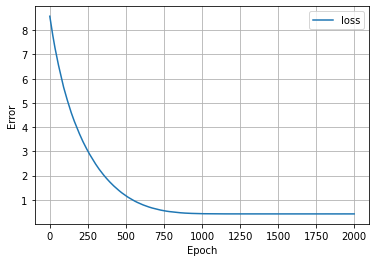

In [9]:
model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=0) 
print(model.trainable_weights)
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  #plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
plot_loss(model.history)

### Compare the values obtained to Table 3.2 of Elem Stat Learning:

w_esl = [0.68, 0.26, -0.14, 0.21, 0.31, -0.29, -0.02, 0.27],

w_here = [0.89, 0.27, -0.20, 0.25, 0.20, -0.34, -0.12, 0.36].

b_esl = 2.46

b_here = 2.45


In [10]:
if False:
  model.evaluate(test_dataset)

In [11]:
# Prediction Problem
if False:
  y_pred = model.predict(test_dataset)
  for item in y_pred:
    print(item)

In [12]:
if False:
  train_dataset=train_dataset.concatenate(val_dataset)
  model.fit(train_dataset, epochs=EPOCHS, validation_data=train_dataset, verbose=0)
  print(model.evaluate(train_dataset))
  print(model.evaluate(test_dataset))

# Full Simulation
## Full simulation must determine variances in the weights also. For that we will repeat experiment 30 times and report mean and standard error in weight values

In [13]:

def run_experiment(train_dataset, test_dataset, epochs=5, val_dataset=None, trials=30, verbose=0):
  err_in = [] # these are in_sample errorr in each trial
  err_out = [] # out of sample errors
  weights = []
  biases = []
  if val_dataset is not None:
    train_dataset = train_dataset.concatenate(val_dataset) # train on full training set
  else:
    validation_data = train_dataset
  for trial in range(trials):
    model.fit(train_dataset, epochs=epochs, validation_data=validation_data, verbose=verbose)
    e_in = model.evaluate(train_dataset)[-1]
    e_out = model.evaluate(test_dataset)[-1]
    w = model.trainable_weights[0].numpy().flatten()
    b = model.trainable_weights[1].numpy().flatten()
    err_in.append(e_in)
    err_out.append(e_out)
    weights.append(w)
    biases.append(b)
  
  err_in_mean, err_in_stderr = np.mean(err_in), np.std(err_in)/np.sqrt(trials)
  err_out_mean, err_out_stderr = np.mean(err_out), np.std(err_out)/np.sqrt(trials)
  weights_mean, weights_stderr = np.mean(weights,axis=0), np.std(weights, axis=0)/np.sqrt(trials)    
  bias_mean, bias_stderr = np.mean(biases), np.std(biases)/np.sqrt(trials)
  results = (   
      (err_in_mean, err_in_stderr),
      (err_out_mean, err_out_stderr),
      (weights_mean, weights_stderr),
      (bias_mean, bias_stderr)
  )
  return results


#-----------------------------------

full_training_dataset = train_dataset.concatenate(val_dataset)
results = run_experiment(full_training_dataset, test_dataset, epochs=EPOCHS, val_dataset=None, trials=TRIALS, verbose=0)
err_in, err_out, weights, bias = results
print(err_in)
print(err_out)
print(weights)
print(bias)

2/2 [==============================] - 0s 6ms/step - loss: 0.5193 - mean_squared_error: 0.5193
(0.4395078748464584, 5.889699347420175e-05)
(0.5230917433897654, 0.0005952023918760766)
(array([ 0.69761765,  0.28008878, -0.15582432,  0.21069242,  0.29956415,
       -0.26642978, -0.02551241,  0.28679562], dtype=float32), array([0.00103298, 0.00069953, 0.00076815, 0.00084409, 0.00072952,
       0.00084301, 0.00079897, 0.00086109], dtype=float32))
(2.465035, 0.0007592571326949232)
